In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import zipfile

# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  # This should be checked
    'facultative': 'aerobic'  # This should also be checked
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"

# Assuming 'y_processed' is your processed labels DataFrame
# ...

# Feature Selection: Optimize 'k' based on model performance
select_k = SelectKBest(f_classif, k=20)  # Adjust 'k' based on experimentation
X_new = select_k.fit_transform(X_aligned, Y_aligned)


# Hyper parameter tuning



In [29]:
# Data training
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

# Initialize and train the Naive Bayes classifier
GnB = GaussianNB()
GnB.fit(X_train, y_train)

# Predict on the test set
y_pred = GnB.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.872057318321392
Classification Report:
               precision    recall  f1-score   support

     aerobic       0.94      0.90      0.92       795
   anaerobic       0.63      0.75      0.69       182

    accuracy                           0.87       977
   macro avg       0.79      0.83      0.80       977
weighted avg       0.88      0.87      0.88       977



Confusion matrix, without normalization
[[715  80]
 [ 45 137]]
Normalized confusion matrix
[[0.89937107 0.10062893]
 [0.24725275 0.75274725]]


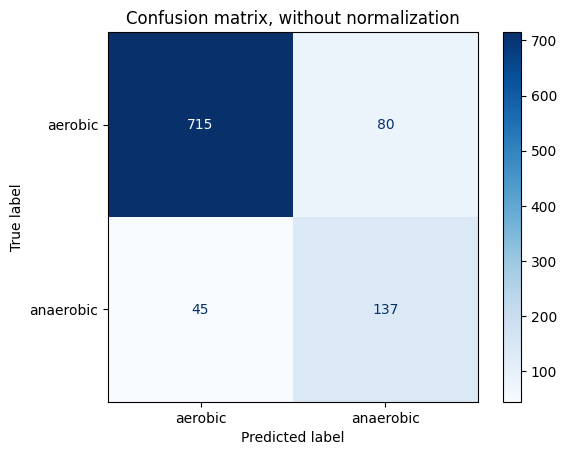

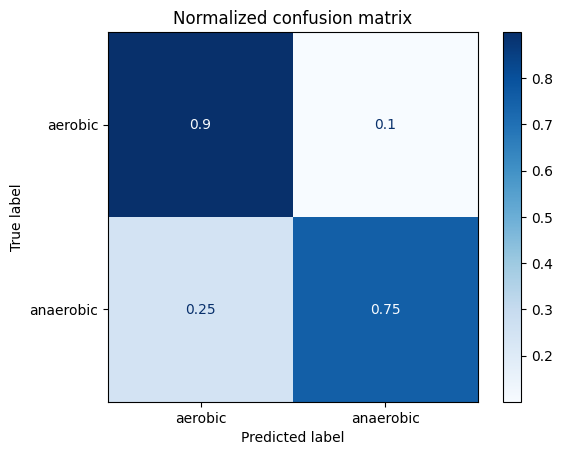

In [30]:
# Conf matrix
# Confusion Matrix Display
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        GnB,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()